In [9]:
import pandas as pd
df = pd.read_csv('./Spam Email raw text for NLP.csv')
df.head()

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


1. Data exploration and visualization.


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CATEGORY   5796 non-null   int64 
 1   MESSAGE    5796 non-null   object
 2   FILE_NAME  5796 non-null   object
dtypes: int64(1), object(2)
memory usage: 136.0+ KB


In [11]:
df['CATEGORY'].value_counts()

CATEGORY
0    3900
1    1896
Name: count, dtype: int64

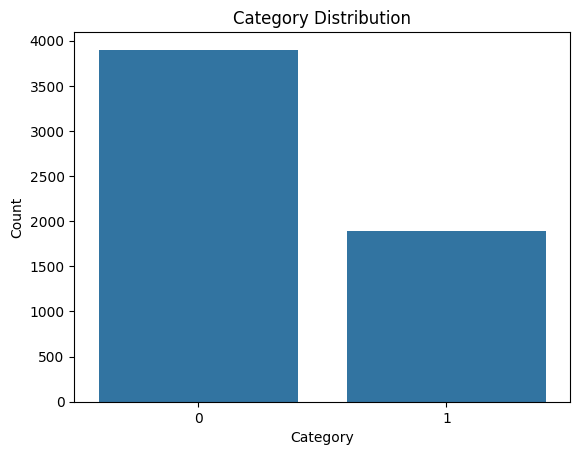

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='CATEGORY', data=df)
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

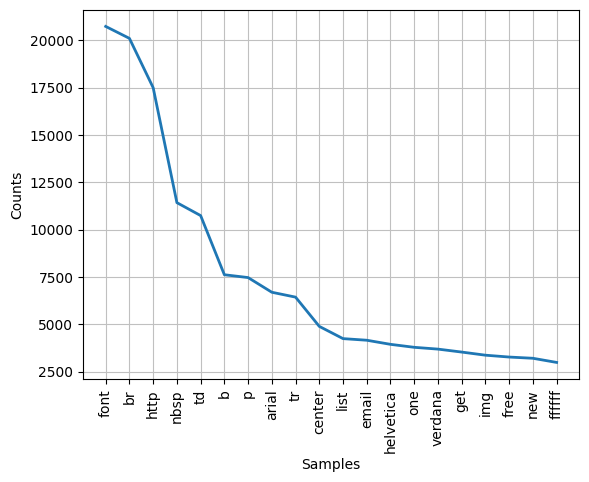

In [13]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

def preprocess_text(text):
    words = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return words

all_words = []
for message in df['MESSAGE']:
    all_words.extend(preprocess_text(message))

fdist = FreqDist(all_words)

fdist.plot(20, cumulative=False)
plt.show()


2. Text cleaning and normalization.


In [14]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')

In [15]:
def clean_message(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords]
    words = [lemmatizer.lemmatize(word) for word in words]
    norm_text = ' '.join(words)

    return norm_text


In [16]:
df['CLEANED_MESSAGE'] = df['MESSAGE'].apply(clean_message)
df['CLEANED_MESSAGE'].head()

0    dear homeowner interest rate lowest point year...
1    attention must computer user newspecial packag...
2    multipart message mime format nextpartcdccbfa ...
3    important information new domain name finally ...
4    bottom line give away cd free people like one ...
Name: CLEANED_MESSAGE, dtype: object

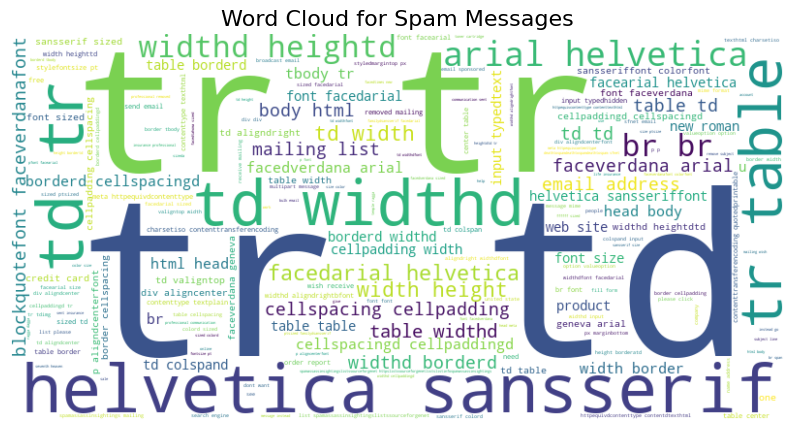

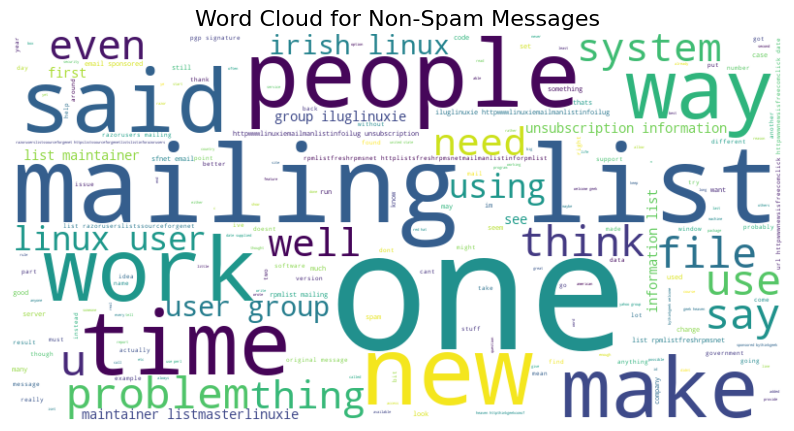

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(data, title):
    combined_text = ' '.join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

spam_messages = df[df['CATEGORY'] == 1]['CLEANED_MESSAGE']
non_spam_messages = df[df['CATEGORY'] == 0]['CLEANED_MESSAGE']

generate_wordcloud(spam_messages, 'Word Cloud for Spam Messages')
generate_wordcloud(non_spam_messages, 'Word Cloud for Non-Spam Messages')


3. Model building

In [21]:
from sklearn.model_selection import train_test_split
X = df['CLEANED_MESSAGE']  
y = df['CATEGORY']         
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       762
           1       0.98      0.98      0.98       398

    accuracy                           0.99      1160
   macro avg       0.99      0.98      0.99      1160
weighted avg       0.99      0.99      0.99      1160



In [24]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       762
           1       0.98      0.95      0.96       398

    accuracy                           0.98      1160
   macro avg       0.98      0.97      0.97      1160
weighted avg       0.98      0.98      0.98      1160



In [25]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       762
           1       0.98      0.98      0.98       398

    accuracy                           0.99      1160
   macro avg       0.99      0.99      0.99      1160
weighted avg       0.99      0.99      0.99      1160



In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       762
           1       0.97      0.96      0.97       398

    accuracy                           0.98      1160
   macro avg       0.98      0.98      0.98      1160
weighted avg       0.98      0.98      0.98      1160

